In [1]:
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
data = np.load("combined_patches.npy",allow_pickle=True)
data = np.array(data,dtype=np.float32)
data = np.random.permutation(data)
print("Shape of data: ", data.shape)
#print(np.unique(data))

#plt.imshow(data[0][1],cmap="gray",vmin=0,vmax=1)
#plt.colorbar()
#plt.show()

Shape of data:  (1000, 2, 256, 256)


In [2]:
train_size, val_size = 800, 150
train_data, val_data, test_data = np.split(data, [train_size, train_size+val_size])
print("Shape of train_data: ", train_data.shape)
print("Shape of val_data: ", val_data.shape)
print("Shape of test_data: ", test_data.shape)

Shape of train_data:  (800, 2, 256, 256)
Shape of val_data:  (150, 2, 256, 256)
Shape of test_data:  (50, 2, 256, 256)


In [3]:
import torch
import torch.nn.functional as F

def compute_cell_distance_map(binary_tensor, max_dist=60):
    """
    Compute distance map from cell pixels to nearest background.
    
    Args:
        binary_tensor: Binary tensor with 1=cell, 0=background [B, 1, H, W]
        
    Returns:
        Distance map: 0 at cell boundaries, increasing inward
    """
    # Invert the binary image to compute distances from foreground to background
    inverted = 1.0 - (binary_tensor > 0.5).float()
    
    # Initialize distance map (0 for background, max_dist for cells)
    dist_map = torch.zeros_like(binary_tensor)
    dist_map[binary_tensor > 0.5] = max_dist
    
    # Current boundary pixels (initially all background pixels)
    boundary = inverted.clone()
    
    # Propagation kernel
    kernel = torch.ones(1, 1, 3, 3).to(binary_tensor.device)
    
    # Iteratively propagate distances
    for d in range(1, max_dist):
        # Dilate current boundary
        dilated = F.conv2d(
            F.pad(boundary, (1, 1, 1, 1), mode='constant', value=0),
            kernel, padding=0
        ) > 0
        
        # New boundary is cells that weren't assigned a distance yet
        new_boundary = dilated & (dist_map == max_dist)
        
        # Update distance values for new boundary
        dist_map[new_boundary] = d
        
        # Update boundary for next iteration
        boundary = new_boundary.float()
        
        # Early stop if no new pixels reached
        if not new_boundary.any():
            break
    
    # Keep only the cell distances (set background to 0)
    dist_map = dist_map * (binary_tensor > 0.5).float()
    
    # Normalize to [0,1]
    max_val = torch.max(dist_map)
    if max_val > 0:
        dist_map = dist_map / max_val
    
    return dist_map

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 256, 256])


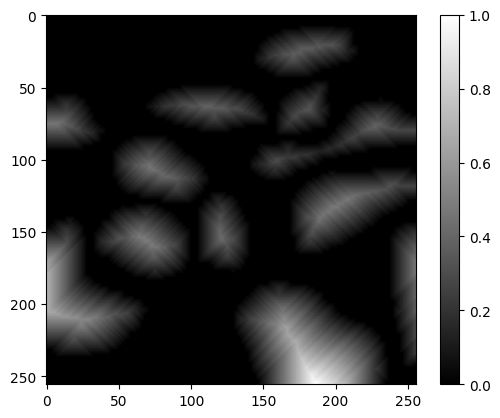

In [4]:
from dataset import SheetletCellDataset
from torchvision import transforms
from matplotlib import pyplot as plt
from scipy.ndimage import distance_transform_edt

transform = transforms.Compose([
        #transforms.Pad(padding=20,padding_mode="reflect"),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(5,fill=0),
        transforms.GaussianBlur(kernel_size=(11,11),sigma=(1,1)),
        #transforms.RandomAffine(0, translate=(0.05,0.05), scale=(0.9,1.15), shear=2),    
    ])

transforms_val = transforms.Compose([   
    transforms.Resize((256,256))])

train_dataset = SheetletCellDataset(train_data, transform=transform)
val_dataset = SheetletCellDataset(val_data)
test_dataset = SheetletCellDataset(test_data)

for i in range(len(train_dataset)):
    print(train_dataset[i][0].shape,train_dataset[i][1].shape)
    condition, target = train_dataset[i]
    device = "cuda" if torch.cuda.is_available() else "cpu"
    target.to(device)
    target_distance = compute_cell_distance_map(target,max_dist=50)
    #plt.imshow(condition[0],cmap="gray",vmin=0,vmax=1)
    #plt.imshow(target[0],cmap="gray",vmin=0,vmax=1,alpha=0.5)
    #target_distance = target_distance > 25
    print(target_distance.shape)
    plt.imshow(target_distance[0,:,:],cmap="gray")
    #plt.imshow(target[0],cmap="gray",alpha=0.1)
    plt.colorbar()
    plt.show()
    break

torch.Size([6, 1, 256, 256]) torch.Size([6, 1, 256, 256])


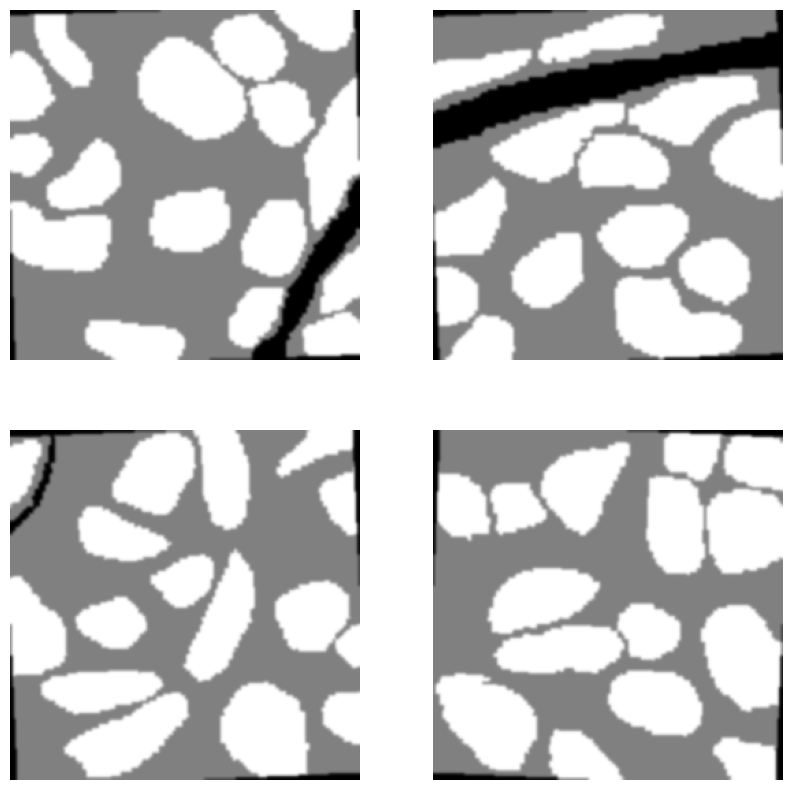

In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=4,pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=6, shuffle=False, num_workers=4,pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=6, shuffle=False, num_workers=4,pin_memory=True)

#get first batch
batch = next(iter(train_dataloader))
print(batch[0].shape,batch[1].shape)

x, y = batch
batch_size = x.shape[0]
fig, axes = plt.subplots(nrows=int(np.sqrt(batch_size)),ncols=int(np.sqrt(batch_size)),figsize=(10,10))
axes = axes.flatten()
for i in range(len(axes)):
    axes[i].imshow(x[i][0],cmap="gray",vmin=0,vmax=1)
    axes[i].imshow(y[i][0],cmap="gray",vmin=0,vmax=1,alpha=0.5)
    axes[i].axis("off")



In [6]:
from model import GANModel
from utils import load_config

config = load_config("config.yaml")
model = GANModel(config, 1e-4, 1e-4)


/home/ignasi/anaconda3/envs/pytorch_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
model

GANModel(
  (generator): Generator(
    (encoder): Encoder(
      (encoder_blocks): ModuleList(
        (0): Sequential(
          (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2)
        )
        (1): Sequential(
          (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2)
        )
        (2): Sequential(
          (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2)
        )
        (3): Sequential(
          (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReL

In [8]:
from pytorch_lightning.loggers import WandbLogger  # Change thisfrom 
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning as pl
import torch
wandb_logger = WandbLogger(
        project="sheetlet-gan",
        name="gan-training-distance",
        log_model=True,
        config=config)
    
checkpoint_callback = ModelCheckpoint(
        monitor="val_g_loss",
        dirpath="checkpoints",
        filename="gan-{epoch:02d}-{val_g_loss:.2f}",
        save_top_k=3,
        mode="min")

In [9]:
trainer = pl.Trainer(
        max_epochs=2000,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=[1],
        logger=wandb_logger,  # Use wandb logger
        callbacks=[checkpoint_callback],
        log_every_n_steps=10,
    )

 

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dataloader, val_dataloader)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ignasialemanyjuv (ignasialemanyjuv-imperial-college-london). Use `wandb login --relogin` to force relogin


/home/ignasi/anaconda3/envs/pytorch_venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/ignasi/Desktop/StyleGAN/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name             | Type              | Params | Mode 
---------------------------------------------------------------
0 | generator        | Generator         | 37.6 M | train
1 | discriminator    | Discriminator     | 2.8 M  | train
2 | adversarial_loss | BCEWithLogitsLoss | 0      | train
3 | l1_loss          | L1Loss            | 0      | train
---------------------------------------------------------------
40.4 M    Trainable params
0         Non-trainable params
40.4 M    Total params
161.592   Total estimated model params size (MB)
79        Modules in train mode
0         Modules in eval mode


Epoch 8: 100%|██████████| 134/134 [00:21<00:00,  6.21it/s, v_num=9u7d, g_loss_l1_step=38.40, g_loss_adv_step=0.682, g_loss_distance_step=47.20, g_loss_step=86.30, d_loss_real_step=0.566, d_loss_fake_step=0.726, d_loss_step=0.646, val_g_loss=69.50, val_g_loss_adv=0.687, val_g_loss_l1=40.90, val_g_loss_distance=27.90, val_d_loss=0.693, val_d_loss_real=0.676, val_d_loss_fake=0.709, g_loss_l1_epoch=37.70, g_loss_adv_epoch=0.697, g_loss_distance_epoch=48.40, g_loss_epoch=86.80, d_loss_real_epoch=0.567, d_loss_fake_epoch=0.698, d_loss_epoch=0.633]